In [1]:
import numpy as py
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

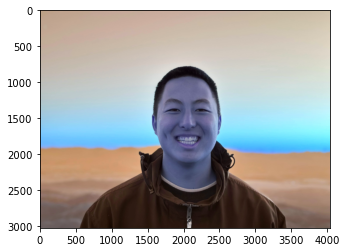

In [2]:
img = cv2.imread('./Photos/Joshua/IMG_3805.jpg')
img.shape
plt.imshow(img)

In [3]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape

(3024, 4032)

In [4]:
gray

array([[156, 156, 156, ..., 189, 189, 189],
       [156, 156, 156, ..., 189, 189, 189],
       [156, 156, 156, ..., 189, 189, 189],
       ...,
       [ 95,  95,  95, ...,  98,  98,  98],
       [ 95,  95,  95, ...,  98,  98,  98],
       [ 95,  95,  95, ...,  98,  98,  98]], dtype=uint8)

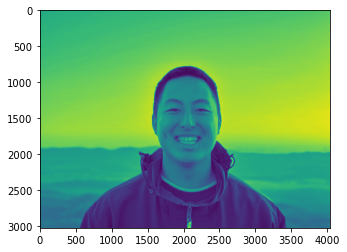

In [5]:
plt.imshow(gray)

In [6]:
face_cascade = cv2.CascadeClassifier('./haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./haarcascades/haarcascade_eye.xml')
faces = face_cascade.detectMultiScale(gray, 1.3,5)
faces

array([[1508,  973, 1028, 1028]])

In [7]:
(x,y,w,h) = faces[0]
x,y,w,h

(1508, 973, 1028, 1028)

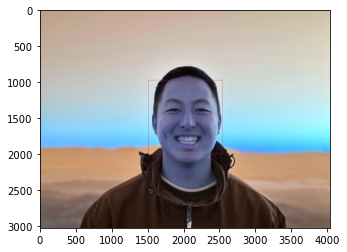

In [8]:
face_img = cv2.rectangle(img,(x,y),(x+w, y+h),(255,0,0),2)
plt.imshow(face_img)

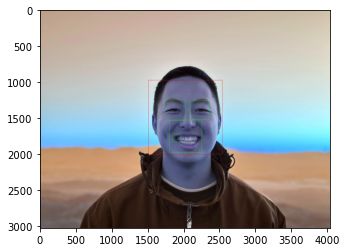

In [9]:
cv2.destroyAllWindows()
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img,(x,y),(x+w, y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = face_img[y:y+h,x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew, ey+eh),(0,255,0),2)

plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()

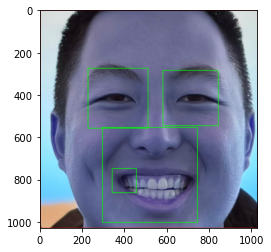

In [10]:
%matplotlib inline
plt.imshow(roi_color, cmap= 'gray')

In [139]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    if(img is not None):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3,5)
        for (x,y,w,h) in faces:
            roi_gray = gray[y:y+h, x:x+w]
            roi_color = img[y:y+h, x:x+w]
            eyes = eye_cascade.detectMultiScale(roi_gray)
            if len(eyes) >= 2:
                return roi_color

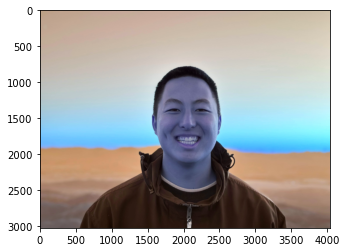

In [140]:
orginial_image = cv2.imread('./Photos/Joshua/IMG_3805.jpg')
plt.imshow(orginial_image)

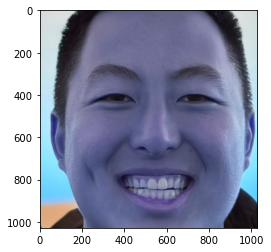

In [141]:
cropped_image = get_cropped_image_if_2_eyes('./Photos/Joshua/IMG_3805.jpg')
plt.imshow(cropped_image)

In [181]:
path_to_data = "./Photos/"
path_to_cr_data = "./Photos/cropped/"

In [182]:
import os 
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [183]:
img_dirs

['./Photos/Braden',
 './Photos/Chen',
 './Photos/Joshua',
 './Photos/Kim-Sejong',
 './Photos/Scott']

In [184]:
import shutil 
if os.path.exists(path_to_cr_data):
    shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [185]:
cropped_image_dirs = []
friend_file_names_dict = {}

for img_dir in img_dirs:
    count = 1
    friend_name = img_dir.split('/')[-1]
    print(friend_name)
    
    friend_file_names_dict[friend_name] = []
    
    for entry in os.scandir(img_dir): 
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + friend_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ", cropped_folder)
            
            cropped_file_name = friend_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name
            
            cv2.imwrite(cropped_file_path, roi_color)
            friend_file_names_dict[friend_name].append(cropped_file_path)
            count += 1 

Braden
Generating cropped images in folder:  ./Photos/cropped/Braden
Chen
Generating cropped images in folder:  ./Photos/cropped/Chen
Joshua
Generating cropped images in folder:  ./Photos/cropped/Joshua
Kim-Sejong
Generating cropped images in folder:  ./Photos/cropped/Kim-Sejong
Scott
Generating cropped images in folder:  ./Photos/cropped/Scott


In [186]:
import numpy as np
import pywt
import cv2

def w2d(img,mode='haar',level =1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor(imArray, cv2.COLOR_RGB2GRAY)
    #convert to float
    imArray = np.float32(imArray)
    imArray /= 255
    
    coeffs = pywt.wavedec2(imArray,mode,level=level)
    coeffs_H = list(coeffs)
    coeffs_H[0] *= 0; 
    
    imArray_H = pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H *= np.uint8(imArray_H)
    
    return imArray_H



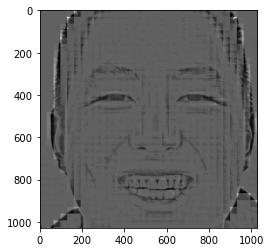

In [187]:
im_har = w2d(cropped_image, 'db1',5)
plt.imshow(im_har, cmap = 'gray')

In [188]:
class_dict = {}
count = 0
for friend_name in friend_file_names_dict.keys():
    class_dict[friend_name] = count
    count = count +1
class_dict

{'Braden': 0, 'Chen': 1, 'Joshua': 2, 'Kim-Sejong': 3, 'Scott': 4}

In [189]:
X, y = [], []
for friend_name, training_files in friend_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        if img is None:
            continue
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[friend_name])     

In [190]:
len(X[0])

4096

In [191]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(243, 4096)

In [192]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [193]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 3))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.6885245901639344

In [194]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.60      0.75      0.67         8
           1       0.71      0.45      0.56        11
           2       0.69      0.73      0.71        15
           3       0.88      0.82      0.85        17
           4       0.50      0.60      0.55        10

    accuracy                           0.69        61
   macro avg       0.68      0.67      0.67        61
weighted avg       0.70      0.69      0.69        61



In [195]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [196]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [199]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.702553,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.559760,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.752553,{'logisticregression__C': 1}


In [200]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, solver='liblinear'))])}

In [201]:
best_estimators['svm'].score(X_test,y_test)

0.7868852459016393

In [202]:
best_estimators['random_forest'].score(X_test,y_test)

0.5737704918032787

In [203]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.7377049180327869

In [204]:
best_clf = best_estimators['svm']

In [206]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[ 6,  1,  0,  0,  1],
       [ 0,  8,  2,  0,  1],
       [ 1,  0, 12,  0,  2],
       [ 0,  1,  0, 15,  1],
       [ 2,  1,  0,  0,  7]], dtype=int64)

Text(69.0, 0.5, 'Truth')

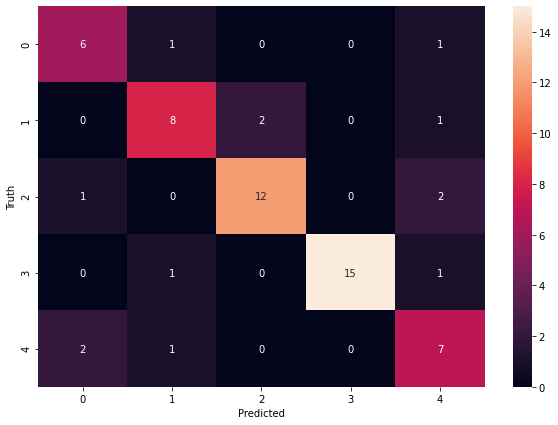

In [207]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [208]:
class_dict

{'Braden': 0, 'Chen': 1, 'Joshua': 2, 'Kim-Sejong': 3, 'Scott': 4}

In [209]:
!pip install joblib
import joblib 
# Save the model as a pickle in a file 
joblib.dump(best_clf, 'saved_model.pkl') 

['saved_model.pkl']

In [210]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))